In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import (
precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# ------------------------------
# 0) Reproducibility & Device
# ------------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# ------------------------------
# 1) Load & Clean
# ------------------------------
df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df = df.dropna(subset=['CustomerID','InvoiceNo','StockCode','Description'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

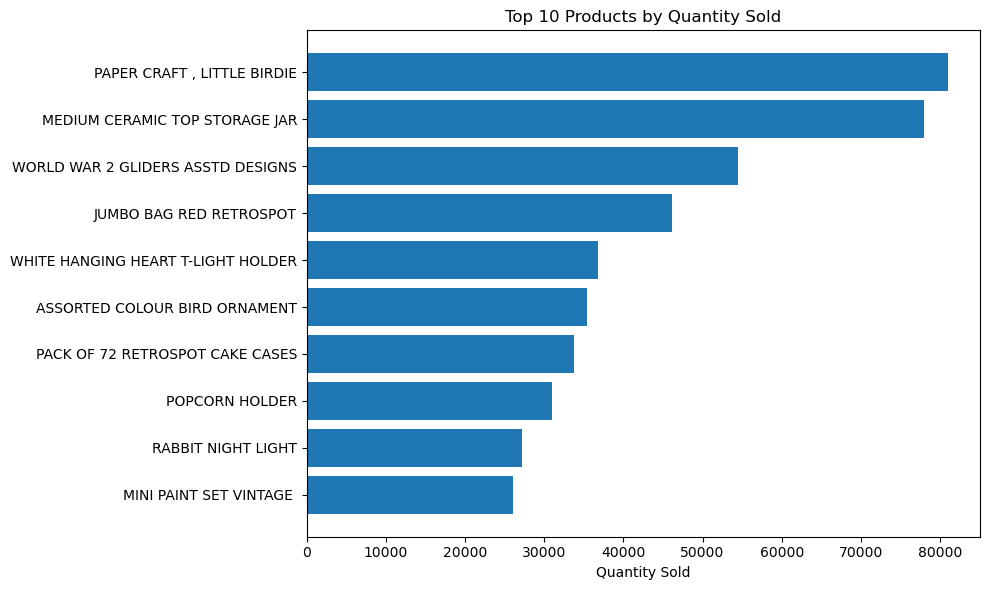

In [6]:
# ------------------------------
# 2) EDA Visualizations (keep!)
# ------------------------------
# Top 10 products by quantity
_top_prod = (df.groupby('Description')['Quantity']
.sum().sort_values(ascending=False).head(10))
plt.figure(figsize=(10,6))
plt.barh(_top_prod.index[::-1], _top_prod.values[::-1])
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.tight_layout(); plt.show()

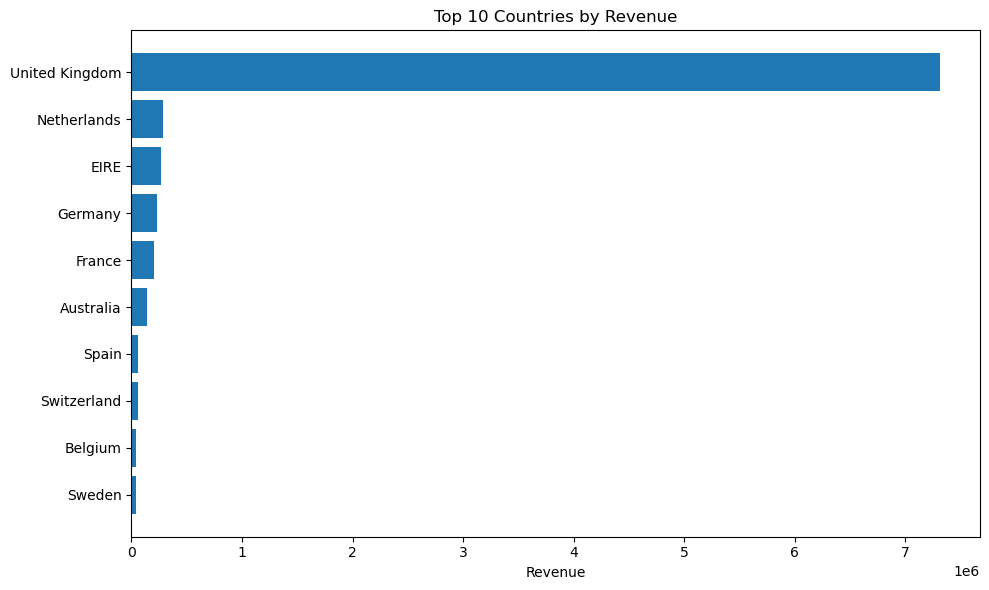

In [7]:
# Top 10 countries by revenue
_top_ctry = (df.groupby('Country')['TotalPrice']
.sum().sort_values(ascending=False).head(10))
plt.figure(figsize=(10,6))
plt.barh(_top_ctry.index[::-1], _top_ctry.values[::-1])
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue')
plt.tight_layout(); plt.show()

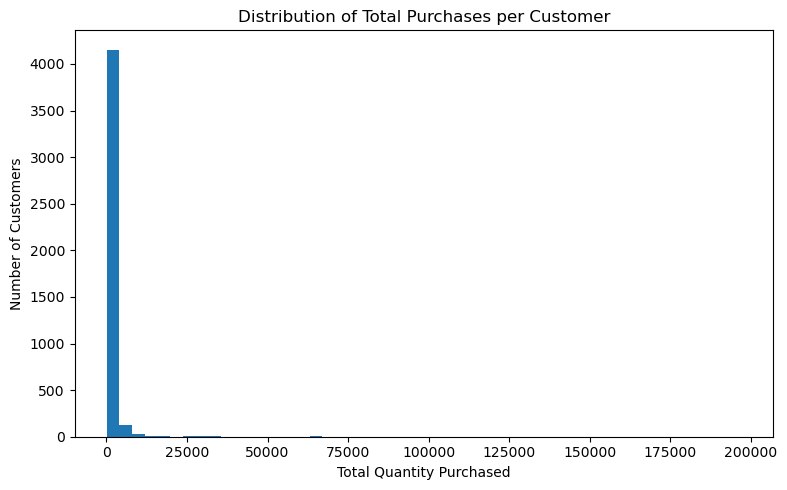

In [8]:
# Customer purchase distribution
_cust_qty = df.groupby('CustomerID')['Quantity'].sum()
plt.figure(figsize=(8,5))
plt.hist(_cust_qty.values, bins=50)
plt.title('Distribution of Total Purchases per Customer')
plt.xlabel('Total Quantity Purchased'); plt.ylabel('Number of Customers')
plt.tight_layout(); plt.show()

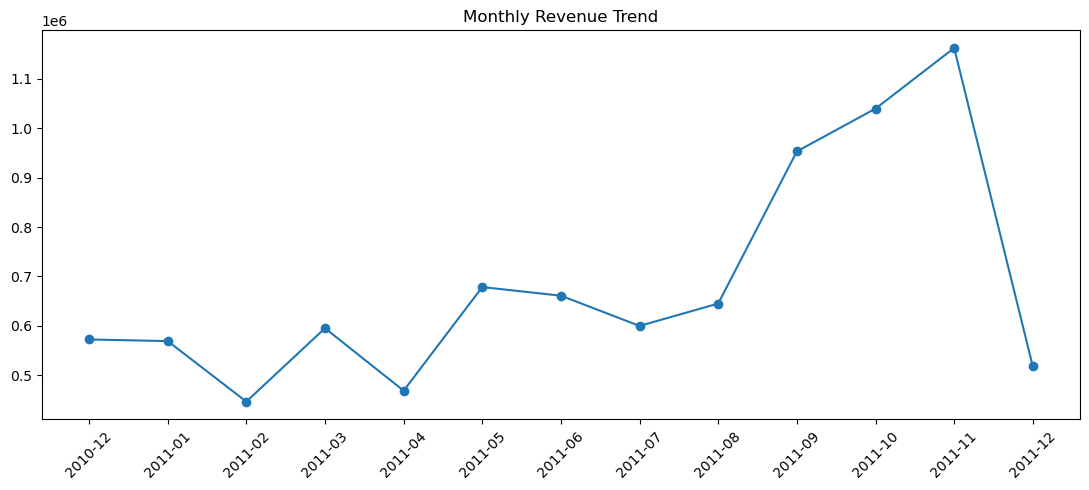

In [9]:
# Monthly revenue trend (seasonality)
df['Month'] = df['InvoiceDate'].dt.to_period('M')
_monthly = df.groupby('Month')['TotalPrice'].sum().reset_index()
_monthly['Month'] = _monthly['Month'].astype(str)
plt.figure(figsize=(11,5))
plt.plot(_monthly['Month'], _monthly['TotalPrice'], marker='o')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

In [10]:
# ------------------------------
# 3) Build Homogeneous Bipartite Graph with Temporal Info
# ------------------------------
# Map users [0..Nc-1], items [Nc..Nc+Np-1]
user_cat = df['CustomerID'].astype('category')
item_cat = df['StockCode'].astype('category')
user_ids = user_cat.cat.codes.values
item_ids = item_cat.cat.codes.values
Nc = len(user_cat.cat.categories)
Np = len(item_cat.cat.categories)
N = Nc + Np

In [11]:
# Month indexing (chronological)
month_periods = np.array(sorted(df['InvoiceDate'].dt.to_period('M').unique()))
month_to_idx = {m:i for i,m in enumerate(month_periods)}
month_idx = df['InvoiceDate'].dt.to_period('M').map(month_to_idx).values
Mmonths = len(month_periods)

In [12]:
# Offset items into same space
u_nodes = user_ids # 0..Nc-1
i_nodes = item_ids + Nc # Nc..N-1

In [13]:
# Time-decay weights (half-life in days)
HALF_LIFE_DAYS = 60
age_days = (df['InvoiceDate'].max() - df['InvoiceDate']).dt.days.values
edge_w = 0.5 ** (age_days / HALF_LIFE_DAYS)


events = pd.DataFrame({
'u': u_nodes,
'i': i_nodes,
'm': month_idx,
'w': edge_w
})

In [14]:
# Split: train = all months except the latest; test = latest month
latest_m = events['m'].max()
train_ev = events[events['m'] < latest_m].reset_index(drop=True)
test_ev = events[events['m'] == latest_m].reset_index(drop=True)

In [15]:
# Build edge tensors
train_edges = torch.tensor(train_ev[['u','i']].values.T, dtype=torch.long)
train_w = torch.tensor(train_ev['w'].values, dtype=torch.float32)
train_m = torch.tensor(train_ev['m'].values, dtype=torch.long)


test_edges = torch.tensor(test_ev[['u','i']].values.T, dtype=torch.long)
test_m = torch.tensor(test_ev['m'].values, dtype=torch.long)

In [16]:
# ------------------------------
# 4) LightGCN with Edge Weights + Month Embeddings
# ------------------------------
class LightGCNTemporal(nn.Module):
    def __init__(self, num_nodes, num_months, emb_dim=64, n_layers=2):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)
        self.month_emb = nn.Embedding(num_months, emb_dim)
        nn.init.xavier_uniform_(self.month_emb.weight)
        self.n_layers = n_layers

    def propagate(self, edge_index, edge_weight):
        # edge_index: [2, E], undirected will be built here
        src, dst = edge_index
        # make undirected by concatenating reverse
        src_all = torch.cat([src, dst], dim=0)
        dst_all = torch.cat([dst, src], dim=0)
        w_all   = torch.cat([edge_weight, edge_weight], dim=0)

        x = self.emb.weight  # [N, d]

        # Weighted degree
        deg = torch.zeros(x.size(0), device=x.device)
        deg.scatter_add_(0, src_all, w_all)
        deg.scatter_add_(0, dst_all, w_all)
        deg_inv_sqrt = torch.pow(deg.clamp(min=1.0), -0.5)

        out = x
        acc = x  # accumulate for layer averaging
        for _ in range(self.n_layers):
            norm = w_all * deg_inv_sqrt[src_all] * deg_inv_sqrt[dst_all]  # [2E]
            msg = x[src_all] * norm.unsqueeze(1)
            out = torch.zeros_like(x)
            out.index_add_(0, dst_all, msg)
            x = out
            acc = acc + x
        return acc / (self.n_layers + 1.0)  # [N, d]

    def score(self, u_vec, i_vec, month_idx):
        m_vec = self.month_emb(month_idx)
        # month affects the user side
        return ( (u_vec + m_vec) * i_vec ).sum(dim=1)

In [17]:
# Instantiate
model = LightGCNTemporal(num_nodes=N, num_months=Mmonths, emb_dim=64, n_layers=2).to(DEVICE)
train_edges_dev = train_edges.to(DEVICE)
train_w_dev     = train_w.to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
EPS = 1e-7

In [18]:
# Helper: sample negatives (keep user range [0,Nc), item range [Nc,N))
def sample_neg(num_samples):
    u = torch.randint(0, Nc, (num_samples,), device=DEVICE)
    i = torch.randint(Nc, N, (num_samples,), device=DEVICE)
    return u, i

In [19]:
# ------------------------------
# 5) Train on historical months (forecast next month)
# ------------------------------
EPOCHS = 20
for ep in range(EPOCHS):
    model.train(); opt.zero_grad()
    X = model.propagate(train_edges_dev, train_w_dev)  # [N,d]

    # Positives
    u_pos = train_edges_dev[0]
    i_pos = train_edges_dev[1]
    m_pos = train_m.to(DEVICE)
    pos_scores = model.score(X[u_pos], X[i_pos], m_pos).sigmoid()

    # Negatives (use same month distribution as positives)
    u_neg, i_neg = sample_neg(len(u_pos))
    idx = torch.randint(0, len(m_pos), (len(u_pos),), device=DEVICE)
    m_neg = m_pos[idx]
    neg_scores = model.score(X[u_neg], X[i_neg], m_neg).sigmoid()

    loss = -torch.log(pos_scores.clamp(min=EPS)).mean() \
           -torch.log((1.0 - neg_scores).clamp(min=EPS)).mean()

    loss.backward(); opt.step()
    print(f"Epoch {ep+1}/{EPOCHS}  Loss: {loss.item():.4f}")

Epoch 1/20  Loss: 1.3863
Epoch 2/20  Loss: 1.3788
Epoch 3/20  Loss: 1.3690
Epoch 4/20  Loss: 1.3566
Epoch 5/20  Loss: 1.3415
Epoch 6/20  Loss: 1.3240
Epoch 7/20  Loss: 1.3039
Epoch 8/20  Loss: 1.2819
Epoch 9/20  Loss: 1.2586
Epoch 10/20  Loss: 1.2344
Epoch 11/20  Loss: 1.2102
Epoch 12/20  Loss: 1.1866
Epoch 13/20  Loss: 1.1649
Epoch 14/20  Loss: 1.1471
Epoch 15/20  Loss: 1.1304
Epoch 16/20  Loss: 1.1169
Epoch 17/20  Loss: 1.1057
Epoch 18/20  Loss: 1.0962
Epoch 19/20  Loss: 1.0874
Epoch 20/20  Loss: 1.0776


In [20]:
# ------------------------------
# 6) Evaluation on latest month (classification + ROC + confusion)
# ------------------------------
model.eval()
with torch.no_grad():
    X = model.propagate(train_edges_dev, train_w_dev)  # use train graph for propagation

    u_test = test_edges[0].to(DEVICE)
    i_test = test_edges[1].to(DEVICE)
    m_test = test_m.to(DEVICE)
    pos_scores = model.score(X[u_test], X[i_test], m_test).sigmoid().cpu().numpy()

    # negatives equal to positives, in test month
    u_neg, i_neg = sample_neg(len(u_test))
    m_neg = m_test[ torch.randint(0, len(m_test), (len(m_test),)) ]
    neg_scores = model.score(X[u_neg], X[i_neg], m_neg).sigmoid().cpu().numpy()

In [21]:
# Metrics
y_true = np.concatenate([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
y_scores = np.concatenate([pos_scores, neg_scores])
y_pred = (y_scores > 0.5).astype(int)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
roc  = roc_auc_score(y_true, y_scores)
print("\n=== Temporal LightGCN (Next-Month Prediction) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")


=== Temporal LightGCN (Next-Month Prediction) ===
Accuracy : 0.7033
Precision: 0.6723
Recall   : 0.7932
F1-score : 0.7278
ROC AUC  : 0.7938


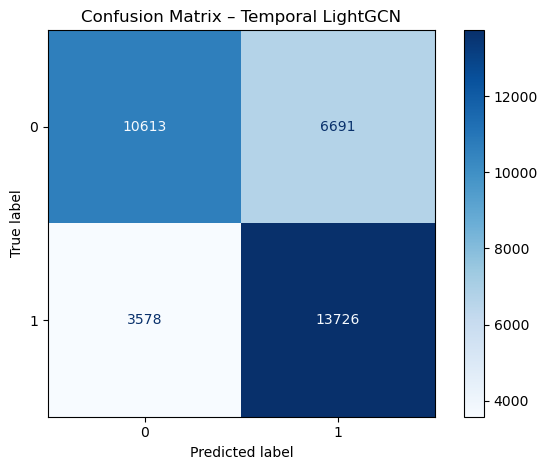

In [22]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix – Temporal LightGCN')
plt.tight_layout(); plt.show()

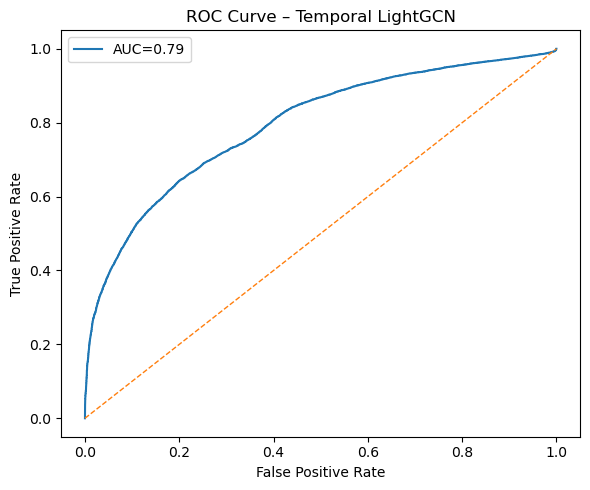

In [23]:
# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc:.2f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Temporal LightGCN')
plt.legend(); plt.tight_layout(); plt.show()

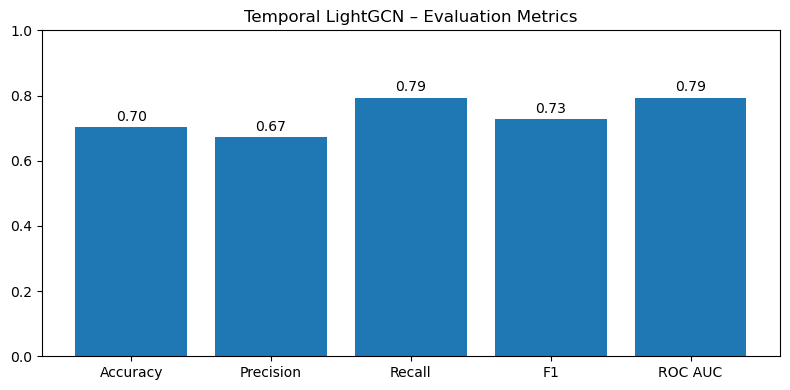

In [24]:
# Bar of classification metrics
names = ['Accuracy','Precision','Recall','F1','ROC AUC']
vals  = [acc, prec, rec, f1, roc]
plt.figure(figsize=(8,4))
_bars = plt.bar(names, vals)
plt.ylim(0,1)
for b,v in zip(_bars, vals):
    plt.text(b.get_x()+b.get_width()/2, v+0.02, f"{v:.2f}", ha='center')
plt.title('Temporal LightGCN – Evaluation Metrics')
plt.tight_layout(); plt.show()

In [25]:
# ------------------------------
# 7) Ranking Metrics @K on next-month forecast
# ------------------------------
# Ground-truth next-month items per user
test_df = test_ev.copy()
user_to_items = test_df.groupby('u')['i'].apply(set).to_dict()
users_in_test = sorted(user_to_items.keys())

# IDCG (scalar version)
def idcg_at_k_scalar(k):
    return float(np.sum([1.0/np.log2(i+2) for i in range(k)]))

def ndcg_at_k(recommended, ground_truth, k):
    dcg = 0.0
    for rank, item in enumerate(recommended[:k]):
        if item in ground_truth:
            dcg += 1.0 / np.log2(rank + 2)
    idcg = idcg_at_k_scalar(min(k, len(ground_truth)))
    return (dcg / idcg) if idcg > 0 else 0.0


def precision_recall_at_k(recommended, ground_truth, k):
    rec_k = recommended[:k]
    hits = len(set(rec_k) & ground_truth)
    prec = hits / max(k,1)
    rec  = hits / max(len(ground_truth),1)
    return prec, rec

# Compute scores matrix for users in test month
with torch.no_grad():
    X = model.propagate(train_edges_dev, train_w_dev)
    user_vecs = X[:Nc].cpu()                         # [Nc,d]
    item_vecs = X[Nc:].cpu()                         # [Np,d]
    mvec = model.month_emb(torch.tensor([latest_m])).cpu()[0]  # [d]

In [26]:
prec_list, rec_list, ndcg_list = [], [], []
K = 10
for u in users_in_test:
    gt = user_to_items[u]
    if len(gt) == 0:
        continue
    u_vec = user_vecs[u] + mvec
    scores = item_vecs @ u_vec  # [Np]
    # Exclude items already bought in train (optional novelty constraint)
    train_items_u = set(train_ev[train_ev['u']==u]['i'].tolist())
    scores_np = scores.numpy()
    scores_np[list(i - Nc for i in train_items_u if i>=Nc)] = -1e9

    topk_items_local = np.argpartition(-scores_np, K)[:K]
    topk_items_local = topk_items_local[np.argsort(-scores_np[topk_items_local])]
    topk_items_global = (topk_items_local + Nc)  # map back to global item nodes

    p, r = precision_recall_at_k(list(topk_items_global), gt, K)
    n = ndcg_at_k(list(topk_items_global), gt, K)
    prec_list.append(p); rec_list.append(r); ndcg_list.append(n)

In [27]:
print(f"\n@{K} Ranking Metrics (Temporal LightGCN):")
print(f"Precision@{K}: {np.mean(prec_list):.4f}")
print(f"Recall@{K}   : {np.mean(rec_list):.4f}")
print(f"NDCG@{K}     : {np.mean(ndcg_list):.4f}")


@10 Ranking Metrics (Temporal LightGCN):
Precision@10: 0.0114
Recall@10   : 0.0054
NDCG@10     : 0.0126


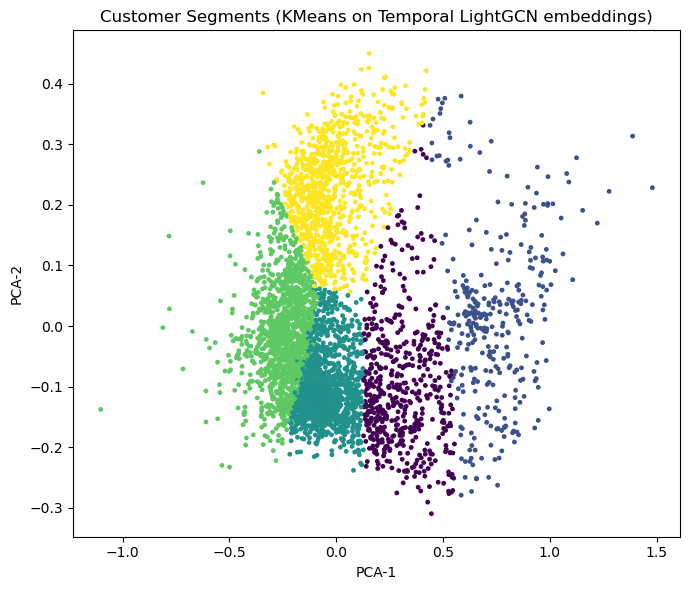

In [28]:
# ------------------------------
# 8) Customer Segmentation on learned embeddings
# ------------------------------
with torch.no_grad():
    X_full = model.propagate(train_edges_dev, train_w_dev).cpu().numpy()
user_emb = X_full[:Nc]
km = KMeans(n_clusters=5, random_state=SEED, n_init='auto').fit(user_emb)
labels = km.labels_

pca = PCA(n_components=2)
user_2d = pca.fit_transform(user_emb)
plt.figure(figsize=(7,6))
plt.scatter(user_2d[:,0], user_2d[:,1], c=labels, s=6)
plt.title('Customer Segments (KMeans on Temporal LightGCN embeddings)')
plt.xlabel('PCA-1'); plt.ylabel('PCA-2')
plt.tight_layout(); plt.show()

In [29]:
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("Cluster sizes (cluster_id: count):")
print(cluster_sizes.to_string())

Cluster sizes (cluster_id: count):
0     531
1     332
2    1309
3    1285
4     881


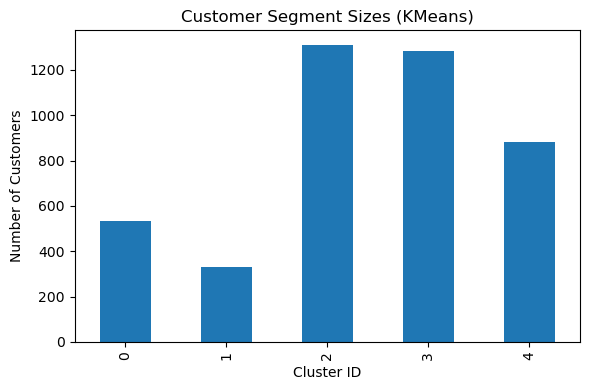

In [30]:
plt.figure(figsize=(6,4))
cluster_sizes.plot(kind='bar')
plt.title('Customer Segment Sizes (KMeans)')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Customers')
plt.tight_layout(); plt.show()

In [31]:
# ------------------------------
# 9) Baseline: Item-based Collaborative Filtering (train on past months)
# ------------------------------
ui_train = train_ev.copy()
ui_train['i_local'] = ui_train['i'] - Nc
num_u, num_i = Nc, Np
M = np.zeros((num_u, num_i), dtype=np.float32)
M[ui_train['u'], ui_train['i_local']] = 1.0

In [32]:
# Item-item cosine similarity (dense; for bigger data consider sparse methods)
S = cosine_similarity(M.T)  # [Np, Np]

prec_cf, rec_cf, ndcg_cf = [], [], []
for u in users_in_test:
    gt = user_to_items[u]
    if len(gt) == 0:
        continue
    scores = M[u] @ S   # [Np]
    # exclude items already bought in train
    train_it = ui_train[ui_train['u']==u]['i_local'].tolist()
    if len(train_it) > 0:
        scores[np.array(train_it, dtype=int)] = -1e9

    topk = np.argpartition(-scores, K)[:K]
    topk = topk[np.argsort(-scores[topk])]
    topk_global = (topk + Nc)  # map back to global item ids

    p, r = precision_recall_at_k(list(topk_global), gt, K)
    n = ndcg_at_k(list(topk_global), gt, K)
    prec_cf.append(p); rec_cf.append(r); ndcg_cf.append(n)

print(f"\n@{K} Ranking Metrics (Item-CF Baseline):")
print(f"Precision@{K}: {np.mean(prec_cf):.4f}")
print(f"Recall@{K}   : {np.mean(rec_cf):.4f}")
print(f"NDCG@{K}     : {np.mean(ndcg_cf):.4f}")


@10 Ranking Metrics (Item-CF Baseline):
Precision@10: 0.0301
Recall@10   : 0.0150
NDCG@10     : 0.0337


In [33]:
# ------------------------------
# 10) Repeat-only Hit@K and classification hit-rates (Objective 2 explicit)
# ------------------------------
# Build train/test user->items maps
train_user_to_items = train_ev.groupby('u')['i'].apply(set).to_dict()
# user_to_items already built for test

# Build Top-K recommendations per user (same as above, using novelty exclusion)
recs_at_k = {}
for u in users_in_test:
    gt = user_to_items[u]
    if len(gt) == 0:
        continue
    u_vec = user_vecs[u] + mvec
    scores = item_vecs @ u_vec  # [Np]
    # exclude items already bought in train
    train_items_u = train_user_to_items.get(u, set())
    scores_np = scores.numpy().copy()
    if train_items_u:
        mask_idx = np.array([i - Nc for i in train_items_u if i >= Nc and (i - Nc) < Np], dtype=int)
        scores_np[mask_idx] = -1e9

    topk_local = np.argpartition(-scores_np, K)[:K]
    topk_local = topk_local[np.argsort(-scores_np[topk_local])]
    topk_global = (topk_local + Nc)
    recs_at_k[u] = list(topk_global)

In [34]:
# Repeat-only Hit@K
repeat_hit_rates = []
for u in users_in_test:
    gt = user_to_items.get(u, set())
    train_items = train_user_to_items.get(u, set())
    repeats_gt = gt & train_items
    if len(repeats_gt) == 0:
        continue
    recs = set(recs_at_k.get(u, []))
    hits = len(repeats_gt & recs)
    repeat_hit_rates.append(hits / len(repeats_gt))

if len(repeat_hit_rates) > 0:
    print(f"Repeat-only Hit@{K} (Temporal LightGCN): {np.mean(repeat_hit_rates):.4f}")
else:
    print("Repeat-only Hit@K: No users with repeat-purchase ground truth in test month.")

Repeat-only Hit@10 (Temporal LightGCN): 0.0000


In [35]:
# Repeat vs Non-repeat classification hit-rates
train_pairs = set(zip(train_ev['u'], train_ev['i']))
repeat_pairs = []
nonrepeat_pairs = []
for (u,i) in zip(test_ev['u'], test_ev['i']):
    if (u,i) in train_pairs:
        repeat_pairs.append((u,i))
    else:
        nonrepeat_pairs.append((u,i))

with torch.no_grad():
    X = model.propagate(train_edges_dev, train_w_dev)
month_vec = torch.tensor([latest_m], device=DEVICE)

repeat_scores = []
nonrepeat_scores = []
for (u,i) in repeat_pairs:
    repeat_scores.append(model.score(X[u], X[i], month_vec).sigmoid().cpu().item())
for (u,i) in nonrepeat_pairs:
    nonrepeat_scores.append(model.score(X[u], X[i], month_vec).sigmoid().cpu().item())

repeat_preds = (np.array(repeat_scores) > 0.5).astype(int) if len(repeat_scores) else np.array([])
nonrepeat_preds = (np.array(nonrepeat_scores) > 0.5).astype(int) if len(nonrepeat_scores) else np.array([])

print(f"\nRepeat-only classification hit-rate (>=0.5): {repeat_preds.mean():.4f}" if repeat_preds.size else "Repeat-only classification hit-rate: N/A (no repeat pairs)")
print(f"Non-repeat classification hit-rate (>=0.5): {nonrepeat_preds.mean():.4f}" if nonrepeat_preds.size else "Non-repeat classification hit-rate: N/A (no non-repeat pairs)")


Repeat-only classification hit-rate (>=0.5): 0.9174
Non-repeat classification hit-rate (>=0.5): 0.6779


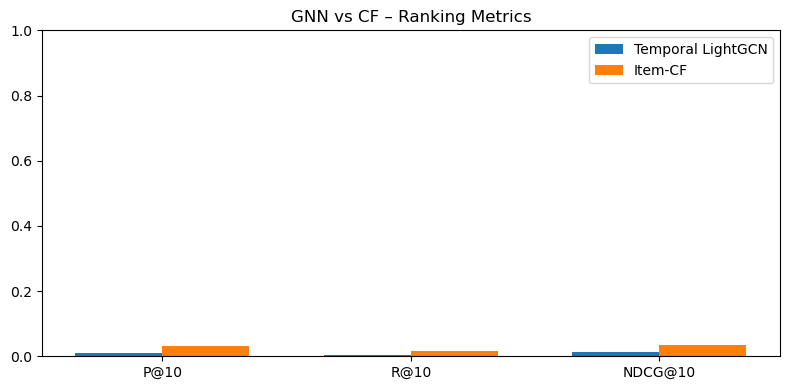

In [36]:
# ------------------------------
# 11) GNN vs CF – Comparison chart
# ------------------------------
names = [f'P@{K}', f'R@{K}', f'NDCG@{K}']
lgcn_vals = [np.mean(prec_list), np.mean(rec_list), np.mean(ndcg_list)]
cf_vals   = [np.mean(prec_cf),   np.mean(rec_cf),   np.mean(ndcg_cf)]
x = np.arange(len(names)); w = 0.35
plt.figure(figsize=(8,4))
plt.bar(x-w/2, lgcn_vals, width=w, label='Temporal LightGCN')
plt.bar(x+w/2, cf_vals,   width=w, label='Item-CF')
plt.xticks(x, names); plt.ylim(0,1)
plt.title('GNN vs CF – Ranking Metrics')
plt.legend(); plt.tight_layout(); plt.show()